In [ ]:
# To-Do
#1) transfer files locally from lxplus or maybe figure out venv on lxplus
#X) CM of phi for image?
#3) bb-center a la photography talk
#4) slide 9: remake these for diHiggs events that have the Higgs back-to-back ie no ISR. Are the blobs more pronounced than non-back-to-back diHiggs events?
#X) increase pixels to see if better? --> 15 -> 25 not really improved
#6) compare expected yields post-selection from this to other approaches. Much higher signal stats here! But by how much?
#7) subtract average a la Anna's idea
#X) store images by jet category?
# ...
# ...
#9) script image making --> different pixel sizes, jet categories
#10) compare ROC curves for different approaches a la Evan's work

In [1]:
# Import the needed libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import os 

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2, l1
from keras.initializers import Constant
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


# Fix random seed for reproducibility
seed = 7
np.random.seed(seed)

import sys
sys.path.insert(0, '/home/btannenw/Desktop/ML/dihiggsMLProject/')
from utils.commonFunctions import *

Using TensorFlow backend.


In [2]:
# Get image data
hh_h5  = h5.File('/home/btannenw/Desktop/ML/dihiggsMLProject/convolutionalNN/pp2hh4b_1M_20files_composite_pix15_phiCM_cat/images/pp2hh4b_1M_20files_composite_pix15_phiCM_cat_allImages.h5', 'r')
qcd_h5 = h5.File('/home/btannenw/Desktop/ML/dihiggsMLProject/convolutionalNN/ppTo4b_4M_20files_composite_pix15_phiCM_cat/images/ppTo4b_4M_20files_composite_pix15_phiCM_cat_allImages.h5', 'r')

In [ ]:
# Make composite dihiggs images
#hh_combImages = []
##for iEvt in range(0, len(hh_imgs['trackImgs'])):
#for iEvt in range(0, 5000):
#    if iEvt%500 == 0:
#        print('Processed {} dihiggs events'.format(iEvt) )
#    hh_combImages.append( np.stack( (hh_imgs['trackImgs'][iEvt], hh_imgs['nHadronImgs'][iEvt], hh_imgs['photonImgs'][iEvt]), axis=-1) )
#print(len(hh_combImages))

#hh = np.stack( (hh_combImages), axis=0)

In [ ]:
hh_h5.keys()

In [18]:
# Read data
#nEvents = 49757
#hh = hh_h5['compositeImgs'][:nEvents]
#qcd = qcd_h5['compositeImgs'][:nEvents]

#hh = hh_h5['compositeImgs']
#qcd = qcd_h5['compositeImgs']

hh = hh_h5['compositeImgs_<4j']
qcd = qcd_h5['compositeImgs_<4j']

print(len(hh), len(qcd))
#hh = list(hh)
#qcd = list(qcd)

In [ ]:
#nEvents_4j = 19000
#hh_4j = hh_h5['compositeImgs_4j'][:nEvents_4j]
#qcd_4j = qcd_h5['compositeImgs_4j'][:nEvents_4j]

hh_4j = hh_h5['compositeImgs_<4j']
qcd_4j = qcd_h5['compositeImgs_<4j']
hh_4j0b = hh_h5['compositeImgs_>=4j0b']
qcd_4j0b = qcd_h5['compositeImgs_>=4j0b']
hh_4j1b = hh_h5['compositeImgs_>=4j1b']
qcd_4j1b = qcd_h5['compositeImgs_>=4j1b']

hh_4j2b = hh_h5['compositeImgs_>=4j2b']
qcd_4j2b = qcd_h5['compositeImgs_>=4j2b']
hh_4j3b = hh_h5['compositeImgs_>=4j3b']
qcd_4j3b = qcd_h5['compositeImgs_>=4j3b']
hh_4j4b = hh_h5['compositeImgs_>=4j4b']
qcd_4j4b = qcd_h5['compositeImgs_>=4j4b']

hh_g4j4b = hh_h5['compositeImgs_>=4j>=4b']
qcd_g4j4b = qcd_h5['compositeImgs_>=4j>=4b']

#hh_all = list(hh_4j) + list(hh_4j0b) + list(hh_4j1b) + list(hh_4j2b) + list(hh_4j3b) + list(hh_4j4b) + list(hh_g4j4b)
print(len(hh), len(qcd), len(hh_4j)+len(hh_4j0b)+len(hh_4j1b)+len(hh_4j2b)+len(hh_4j3b)+len(hh_4j4b)+len(hh_g4j4b), len(hh_all))

In [19]:
#nEvents = min(len(hh), len(qcd))
#nEvents = min(len(hh_imgs['compositeImgs']), len(qcd_imgs['compositeImgs']))

# Make labels
hh_labels = np.ones( len(hh) )
qcd_labels = np.zeros( len(qcd) )

# Make combined dataset
#all_images = np.concatenate ( (hh.copy(), qcd.copy()), axis=0)
all_images = np.concatenate ( (hh, qcd) )
all_labels = np.concatenate ( (hh_labels.copy(), qcd_labels.copy()), axis=0)
print(all_images.shape, all_labels.shape)

#all_images, all_labels = shuffle(all_images, all_labels, random_state=0)
imgs_train, imgs_test, labels_train, labels_test = train_test_split(all_images, all_labels, test_size=0.25, shuffle= True, random_state=30)

(80833, 15, 15, 3) (80833,)


In [20]:
# Layer options
l2_reg = tf.keras.regularizers.l2(1e-4)
conv_kwargs = dict(
            activation="relu",
            #kernel_initializer=tf.keras.initializers.lecun_normal(),
            #kernel_regularizer=l2_reg,
    )

dense_kwargs = conv_kwargs

# bias options
initial_bias = np.log([len(hh)/len(qcd)])
output_bias = Constant(initial_bias)
print("initial bias: {}".format(initial_bias))

# class weights
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
total = len(qcd) + len(hh)
weight_for_0 = (1 / len(qcd))*(total)/2.0 
weight_for_1 = (1 / len(hh))*(total)/2.0
class_weight = {0: weight_for_0, 1: weight_for_1}
print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

initial bias: [-1.35774509]
Weight for class 0: 0.63
Weight for class 1: 2.44


In [21]:
def evaluateModel( _model, _history, _data, _labels):
    # *** A. Make prediction data
    hh_data_test    = np.asarray([x for x,y in zip(_data, _labels) if y==1])
    hh_labels_test  = np.asarray([y for x,y in zip(_data, _labels) if y==1])
    qcd_data_test   = np.asarray([x for x,y in zip(_data, _labels) if y==0])
    qcd_labels_test = np.asarray([y for x,y in zip(_data, _labels) if y==0])

    # *** B. Load model 

    # *** C. Make history plots
    print("*** Training History Plots")
    makeHistoryPlots( _history, ['accuracy', 'loss', 'auc'] )

    # *** C. Make predictions
    score_hh = _model.evaluate(hh_data_test, hh_labels_test)
    score_qcd = _model.evaluate(qcd_data_test, qcd_labels_test)
    print(score_hh, score_qcd)
    pred_hh = _model.predict(hh_data_test)
    pred_qcd = _model.predict(qcd_data_test)
    
    # *** D. make output score plot
    print("*** Output Score Plot")
    _nBins = 40
    predictionResults = {'hh_pred':pred_hh, 'qcd_pred':pred_qcd}
    compareManyHistograms( predictionResults, ['hh_pred', 'qcd_pred'], 2, 'Signal Prediction', 'CNN Score', 0, 1, _nBins, _yMax = 5, _normed=True, savePlot=False )

    # *** E. Get best cut value for CNN assuming some minimal amount of signal
    pred_hh_sig = [x[0] for x in pred_hh.copy()]
    pred_qcd_sig = [x[0] for x in pred_qcd.copy()]

    sig, cut, sigErr = returnBestCutValue('CNN', pred_hh_sig, pred_qcd_sig, _minBackground=400e3, _testingFraction=0.025)
    
    # *** F. Confusion matrix
    print("*** Confusion Matrix")
    preds_test = _model.predict(_data)
    cm = confusion_matrix( _labels, preds_test > cut)
    print(cm)
    print('QCD called QCD (True Negatives): {} ({}%)'.format( cm[0][0], round(100*(cm[0][0]/sum(cm[0]))) ))
    print('QCD called Dihiggs (False Positives):  {} ({}%)'.format( cm[0][1], round(100*(cm[0][1]/sum(cm[0]))) ))
    print('Dihiggs called QCD (False Negatives):  {} ({}%)'.format( cm[1][0], round(100*(cm[1][0]/sum(cm[1]))) ))
    print('Dihiggs called Dihiggs (True Positives):  {} ({}%)'.format( cm[1][1], round(100*(cm[1][1]/sum(cm[1]))) ))
    print('Total Dihiggs: ', np.sum(cm[1]))
    
    # *** 7. Make ROC curve
    print("*** ROC Curve")
    makeEfficiencyCurves( dict(label="CNN", labels=_labels, prediction=preds_test, color="blue"), _modelName='CNN')
    #utils/commonFunctions.py:def makeEfficiencyCurves(*data, _modelName='', savePlot=False, saveDir=''):

In [36]:
def makeModelCNN(pixelWidth=15, savedModel=''):
    # Define model
    _model = Sequential()

    # Convolutional part
    _model.add( Conv2D(16, (3, 3), input_shape=(pixelWidth, pixelWidth, 3), **conv_kwargs) )
    _model.add( MaxPooling2D((2, 2)) )
    _model.add( Conv2D(32, (3, 3), **conv_kwargs))
    _model.add( MaxPooling2D((2, 2)))
    _model.add( Conv2D(32, (2, 2), **conv_kwargs))
    #model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    # Feed-forward part
    _model.add( Flatten())
    _model.add( Dense(64, **dense_kwargs))
    _model.add( BatchNormalization() )
    _model.add( Dense(64, **dense_kwargs))
    #model.add( Dropout(0.2) )
    _model.add( Dense(1, activation='sigmoid', bias_initializer=output_bias) )
    
    _model.summary()
    
    metrics = [ #tf.keras.metrics.categorical_accuracy,
            'accuracy',
            tf.keras.metrics.AUC(name='auc'),
    ]

    _model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=metrics)
              #metrics=['accuracy'])
    
    
    if savedModel !='':
        local_dir = os.path.join(savedModel, "models")
        modelfile = os.path.join(local_dir, savedModel)+'.hdf5'
        print("++ loading model from {}".format(modelfile))
        if not os.path.isfile(modelfile):
            print("--- ERROR, Modelfile {} NOT FOUND. No weights initialized".format(modefile))
            return
        
        _model.predict( np.empty( (pixelWidth, pixelWidth, 3) ))
        _model.load_weights(modelfile)

    return _model


In [23]:
# *** 1. Define output directory
topDir = "composite_pixel25_3conv"
name = 'epochs15'
if not os.path.exists(topDir):
    os.makedirs(topDir)
model_dir = os.path.join(topDir, "", "models")
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
# *** 2. Define callbacks for training
fit_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(model_dir, name)+'.hdf5',
            save_best_only=True,
            save_weights_only=True,
            #monitor="val_auc",
            #mode="max",
            monitor="val_loss",
            mode="min",
        ),
    tf.keras.callbacks.EarlyStopping(
            #monitor="val_auc",
            #mode="max",
            monitor='val_loss', 
            mode='min', 
            verbose=1, 
            patience=15,  
            min_delta=.0025,
        ),
    ]

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 13, 13, 16)        448       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 32)          4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 1, 1, 32)          4128      
_________________________________________________________________
flatten_4 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)               

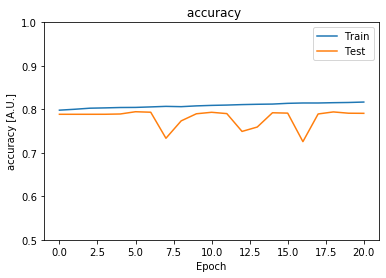

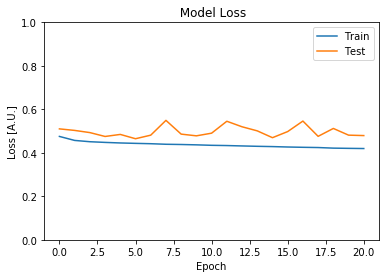

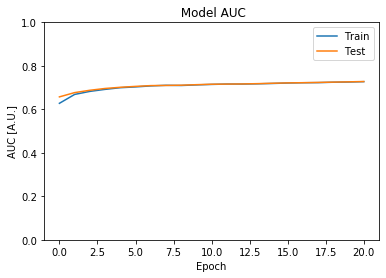

15937/15937 [==============================] - 2s 155us/step
[1.523003959477171, 0.10135767608880997, 0.7274339199066162] [0.19959373674716885, 0.975654125213623, 0.7272058129310608]
*** Output Score Plot


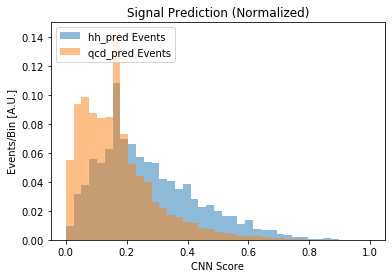

4272 15937
nSig = 8071.57 , nBkg = 148281392.28 with significance = 0.663 +/- 0.013 for CNN score > 0.181
*** Confusion Matrix
[[10344  5593]
 [ 1551  2721]]
QCD called QCD (True Negatives): 10344 (65.0%)
QCD called Dihiggs (False Positives):  5593 (35.0%)
Dihiggs called QCD (False Negatives):  1551 (36.0%)
Dihiggs called Dihiggs (True Positives):  2721 (64.0%)
Total Dihiggs:  4272
*** ROC Curve


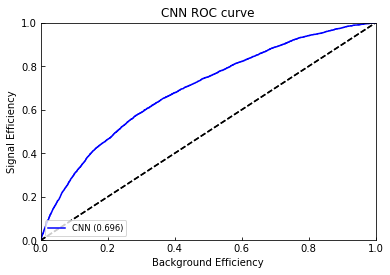

In [24]:
# *** 3A. Train without weights
modelNoWeights = makeModelCNN()

historyNoWeights = modelNoWeights.fit(imgs_train, labels_train, epochs=50, 
                    shuffle=True,
                    batch_size=512,
                    validation_data=(imgs_test, labels_test),
                    callbacks=fit_callbacks,
                    )

evaluateModel( modelNoWeights, historyNoWeights, imgs_test, labels_test)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 13, 13, 16)        448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 32)          4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1, 1, 32)          4128      
_________________________________________________________________
flatten_2 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

6783/6783 [==============================] - 1s 156us/step - loss: 0.2612 - accuracy: 0.8869 - auc: 0.8051 - val_loss: 0.6944 - val_accuracy: 0.6706 - val_auc: 0.8063
Epoch 38/50
6783/6783 [==============================] - 1s 148us/step - loss: 0.2514 - accuracy: 0.8941 - auc: 0.8085 - val_loss: 0.8452 - val_accuracy: 0.6680 - val_auc: 0.8093
Epoch 39/50
6783/6783 [==============================] - 1s 141us/step - loss: 0.2457 - accuracy: 0.8947 - auc: 0.8112 - val_loss: 0.7768 - val_accuracy: 0.6715 - val_auc: 0.8121
Epoch 40/50
6783/6783 [==============================] - 1s 144us/step - loss: 0.2290 - accuracy: 0.9046 - auc: 0.8142 - val_loss: 0.8024 - val_accuracy: 0.6569 - val_auc: 0.8151
Epoch 00040: early stopping
*** Training History Plots


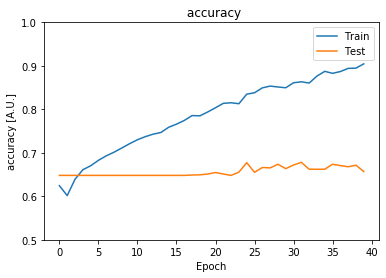

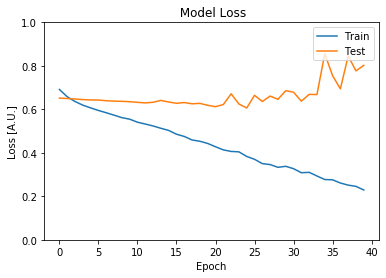

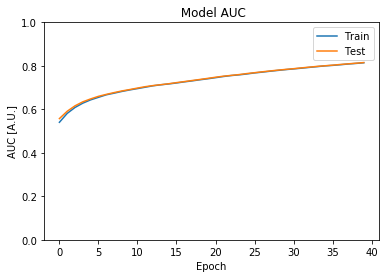

796/796 [==============================] - 0s 123us/step
[0.3816523764988898, 0.8206002712249756, 0.8147740364074707] [1.5772821771439596, 0.3555276393890381, 0.8140406608581543]
*** Output Score Plot


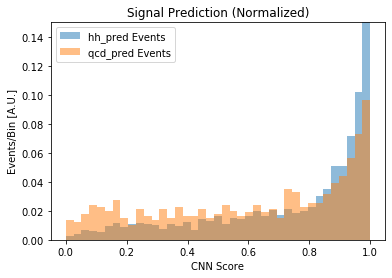

1466 796
nSig = 3710.97 , nBkg = 14581578.0 with significance = 0.972 +/- 0.034 for CNN score > 0.437
*** Confusion Matrix
[[ 246  550]
 [ 215 1251]]
QCD called QCD (True Negatives): 246 (31.0%)
QCD called Dihiggs (False Positives):  550 (69.0%)
Dihiggs called QCD (False Negatives):  215 (15.0%)
Dihiggs called Dihiggs (True Positives):  1251 (85.0%)
Total Dihiggs:  1466
*** ROC Curve


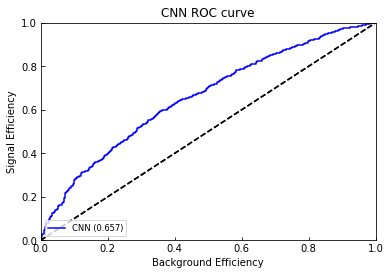

In [10]:
# *** 3B. Train without weights
modelWeighted = makeModelCNN()

historyWeighted = modelWeighted.fit(imgs_train, labels_train, epochs=50, 
                    shuffle=True,
                    batch_size=512,
                    validation_data=(imgs_test, labels_test),
                    callbacks=fit_callbacks,
                    class_weight=class_weight
                   )

evaluateModel( modelWeighted, historyWeighted, imgs_test, labels_test)


In [ ]:
 # *** 7. Make overlaid ROC curves
predsNoWeights = modelNoWeights.predict(imgs_test)
predsWeighted  = modelWeighted.predict(imgs_test)
overlay = [ dict(label="No Weights", labels=labels_test, prediction=predsNoWeights, color="blue"),
            dict(label="Weighted", labels=labels_test, prediction=predsWeighted, color="red")
          ]
overlayROCCurves( overlay )

In [ ]:
# *** 4B. Get signifiance for any user-specified NN score cut value
testingFraction = 0.1
lumiscale_hh  = getLumiScaleFactor(testingFraction, True, 25e3)
lumiscale_qcd = getLumiScaleFactor(testingFraction, False, 50e3)
cut = 0.48
_nSignal = sum( value > cut for value in pred_hh_sig)*lumiscale_hh
_nBackground = sum( value > cut for value in pred_qcd_sig)*lumiscale_qcd

print('nSig = {0} , nBkg = {1} with significance = {2} for NN score > {3}'.format(_nSignal, _nBackground, _nSignal/np.sqrt(_nBackground), cut) )

In [34]:
a = np.empty((15, 15, 3))

In [35]:
a

array([[[6.94784412e-310, 6.94784412e-310, 4.66881659e-310],
        [4.66881659e-310, 4.94065646e-324, 4.66881659e-310],
        [4.94065646e-324, 4.66881659e-310, 5.46453128e-095],
        [6.94784359e-310, 6.98345501e-077, 1.03080217e+136],
        [4.94065646e-324, 3.24249305e-086, 6.94784263e-310],
        [6.01346930e-154, 7.06652016e-096, 8.48798316e-314],
        [8.94213053e+130, 4.66881659e-310, 6.94784359e-310],
        [9.37041156e-076, 8.48798316e-314, 4.94065646e-324],
        [4.66881659e-310, 1.48219694e-323, 4.66881659e-310],
        [4.66881659e-310, 4.66881659e-310, 4.66881514e-310],
        [6.94784403e-310, 8.39911598e-323, 6.94784403e-310],
        [2.97079411e-313, 8.39911598e-323, 6.94784403e-310],
        [7.06673028e-096, 6.94784403e-310, 3.81959242e-313],
        [1.05089587e-153, 6.94784403e-310, 6.01346930e-154],
        [6.94784403e-310, 4.66839074e-313, 6.01346930e-154]],

       [[6.94777410e-310, 4.07356292e+223, 4.66881659e-310],
        [2.97079411e-3